In [1]:
from cmdstanpy import CmdStanModel, cmdstan_path, install_cmdstan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import warnings

warnings.filterwarnings('ignore')

%load_ext pycodestyle_magic
#%pycodestyle_off

# Glicko2: A Probabilistic Chess Rating Framework

**[Introduction](#Introduction)**  
**[Data](#Data)**  
**[Model](#Model)**  
**[Inference](#Inference)**  
**[Criticism](#Criticism)**  

# Introduction <a id='Introduction'></a>

Chess ratings, and rating systems in general, have important implications in head-to-head competitions. Teams and players often get seeded in tournaments or qualify for certain events based on their ratings. Similarly, ratings are also used for match-making, ensuring fairness in such competitions. Thus, it is desirable to have bespoke, probabilistic rating systems that we can explain. In this project, we will use Box's framework to explore the Glicko2 rating system with a focus on inference methods.

![Box's Loop](./img/boxsloop.png)

## 1. Data <a id='Data'></a>

Our data set, which is taken from the [Kaggle Deloitte/FIDE Chess Rating Challenge](https://www.kaggle.com/c/ChessRatings2/data), consists of 2,831 professional chess games played between 103 unique and anonymized players spanning over 12 yearly rating periods. For each game, it includes period number, white and black player IDs as well as game outcome. Please refer to [data/data.ipynb](data/data.ipynb) for data processing details.

## 2. Model <a id='Model'></a>

Our model is Glicko2, the stochastic variance model described in [Glickman (2001)](https://www.glicko.net/research/dpcmsv.pdf). It is a Bayesian probabilistic chess rating framework. Although it was intended as a chess rating system, Glicko2 found many applications in head-to-head competitions (Counter Strike: GO, Lichess, various sports ratings, etc.) and also inspired Microsoft's TrueSkill algorithm [(Minka et al., 2018)](https://www.microsoft.com/en-us/research/publication/trueskill-2-improved-bayesian-skill-rating-system/), which powers many Xbox games.

$$
\begin{aligned}
\tau^2 & \sim InvGamma(3, 2) \\
\\
\sigma^{2^{(0)}} & \sim InvGamma(5, 3) \\
\sigma^{2^{(t+1)}} & \sim LogNormal(log(\sigma^{2^{(t)}}), \tau^2) \\
\\
\gamma^{{(0)}} & \sim Normal(0, \sigma^{2^{(0)}}) \\
\gamma^{{(t+1)}} & \sim Normal(\rho \gamma^{{(t)}}, \sigma^{2^{(t+1)}}) \\
\\
\beta & \sim Normal(0, 5^2) \\
\\
y_i^{(t)} & \sim Bernoulli(InvLogit(\gamma_{i_{white}}^{{(t)}} - \gamma_{i_{black}}^{{(t)}} + \beta))
\end{aligned}
$$

where

- $i$: game $(i = 1, 2, ..., 2831)$
- $t$: period $(t = 1, 2, ..., 12)$
- $\gamma^{(t)}$: player rating at period $t$ (103 unique players)
- $\sigma^{2^{(t)}}$: player rating deviation at period $t$
- $\rho$: autoregressive parameter
- $\beta$: white player advantage
- $y$: binary game outcome

# 3. Inference <a id='Inference'></a>

In [2]:
from inference.inference import hmc, meanfield_vi, map_opt, glickman

glicko_stan = './model/model.stan'
chess_data = './data/processed/data.pkl'
with open(chess_data, 'rb') as f:
    observed_data = pickle.load(f)
glicko_stan = CmdStanModel(stan_file=glicko_stan)

INFO:cmdstanpy:found newer exe file, not recompiling


## 1.Hamiltonian Monte Carlo Markov Chain (HMC)

In this section, we make Bayesian inference by sampling. Specifically, as thought in the class, we sample from the analytically intractable posterior and use them while reasoning about the model. The training procedure and a convergence metric, namely **trace plot** for a parameter $\gamma_{22}$, are as follows:

In [ ]:
glicko_mcmc, score_pp_mcmc = hmc(glicko_stan, observed_data)

INFO:cmdstanpy:CmdStan start procesing
ERROR:cmdstanpy:Error in progress bar initialization:
	IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Disabling progress bars for this session
Exception ignored in: <function tqdm.__del__ at 0x7f81f87309d0>
Traceback (most recent call last):
  File "/home/mk4139/miniconda3/envs/probprog/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/mk4139/miniconda3/envs/probprog/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Some example MCMC statistics:

In [10]:
candidate_parameters = ['gamma[1,4]', 'gamma[8,8]']
print(glicko_mcmc.summary().loc[candidate_parameters])

            Mean   MCSE  StdDev    5%   50%  95%   N_Eff  N_Eff/s  R_hat
name                                                                    
gamma[1,4]  0.51  0.011    0.78 -0.78  0.51  1.8  4906.0      8.6    1.0
gamma[8,8]  1.10  0.014    0.77 -0.17  1.10  2.3  3188.0      5.6    1.0


We see that chains are mixed together, potentially forming $R$ values close to $1$. We also observe this at the above table.

## 2. Mean-Field Variational Inference (VI)

In this section, we use mean-field variational family to approximate the intractavle posterior distribution. The training procedure and a convergence metric, namely **ELBO** by iteration, are as follows:

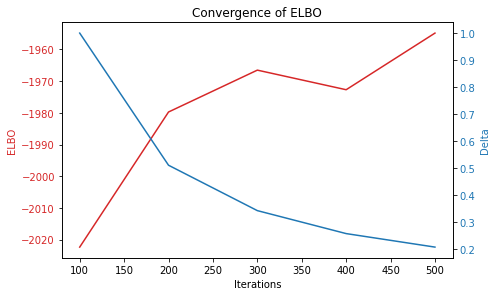

In [11]:
glicko_vi, score_pp_vi = meanfield_vi(glicko_stan, observed_data)

The **ELBO** converges to a local optimum point, smoothly, as seen at the above figure. That is the $\Delta$ between each iteration approaches to a small quantity, $\epsilon$, and the optimization algorithm terminates automatically.

## 3. Maximum a-posteriori Inference (MAP)

In this section, we model the intractable posterior distribution using a Dirac-delta function. This leads to MAP estimate for model parameters:

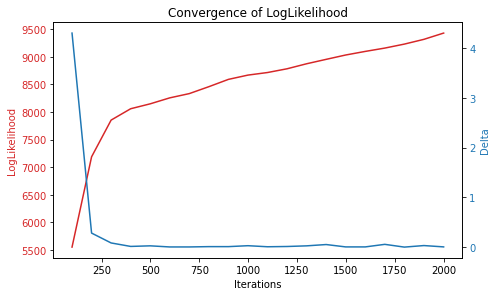

In [12]:
glicko_map, score_pp_map = map_opt(glicko_stan, observed_data)

The **LogLikelihood** converges to a local optimum point, smoothly, as seen at the above figure. That is the $\Delta$ between each iteration approaches to a small quantity, $\epsilon$, and the optimization algorithm terminates automatically.

## 4. Glickman's Algorithm

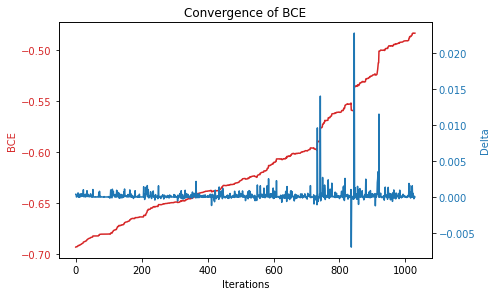

In [127]:
score_pp_glickman, test_probs = glickman(observed_data)

The Bernoulli likelihood of Glickman's algorithm monotonically increases as we perform numberical updates. We observe that the variance of $\Delta$s are larger compared to the previous gradient based algorithms.

## 4. Criticism  <a id='Criticism'></a>

In this section, we criticize our inference algorithms using posterior predictive checks (PPC). Moving forward, we compare the algorithms with each other using the predictions generated by the posterior predictive distribution (for MCMC, VI, and Glickman's algorithm) and point estimates (for MAP algorithm).

In [30]:
from criticism.criticism import plot_ppc

dim = 'period'
check = ['Sum', 'Min','Max']

### 1.Posterior Predictive Checks:

It is hard making posterior predictive checks for Bernoulli distribution. This is because Bernoulli distribution's support is in between $\{0,1\}$, and therefore, test statistics such as minimum and maximum may not be very informative. 

This leads us defining a new random variables for making posterior predictive checks:

1. $X_{total}^{emp}$: Average number of time white player wins throughout all periods. That is the average number of wins in a period.

   $X_{total}^{syn}:$: Average number of time white player wins throughout all periods, predicted by model.   
   
   
2. $X_{min}^{emp}$: The minimum of white player wins throughout all periods. That is the average number of minimum of wins in a period.

   $X_{min}^{syn}:$: The minimum of white player wins throughout all periods, predicted by model. 
   
   
3. $X_{max}^{emp}$: The maximum of white player wins throughout all periods.That is the average number of maximum of wins in a period.

   $X_{max}^{syn}:$: The maximum of white player wins throughout all periods, predicted by model.
   
We are interested in $P(T(X_{*}^{synt}) > T(X_{*}^{emp}))$. Where $T$ changes w.r.t. above items. As an example,  $T$ is the function that takes the average over the number of wins throughout the periods for the first case.

We follow the same procedure as http://www.stat.columbia.edu/~gelman/research/published/dogs.pdf.

**HMC Algorithm:**

Below, we see the posterior predictive checks (with Bayesian p-values) for the **HMC** algorithm:

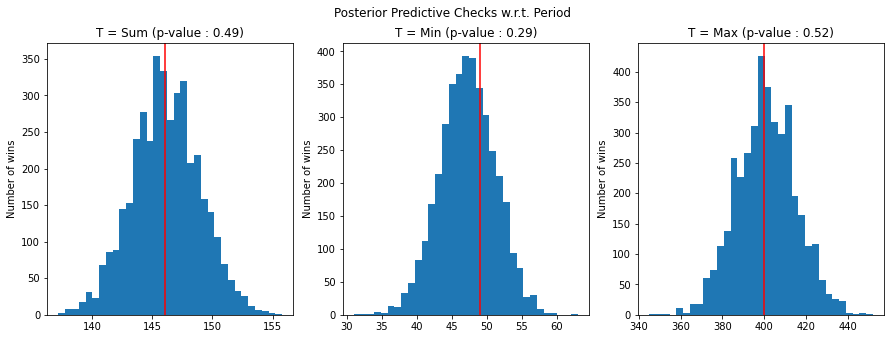

In [31]:
plot_ppc(score_pp_mcmc, observed_data, check, dim)

The simulated and generated data are good fit in terms of $T$=Sum and $T$=Max. However, the distribution of  $T$=Min is right-skewed which may indicate there may be improvement opportunities in the model.

**Mean-field VI Algorithm:**

Below, we see the posterior predictive checks (with Bayesian p-values) for the **Mean-field VI** algorithm:

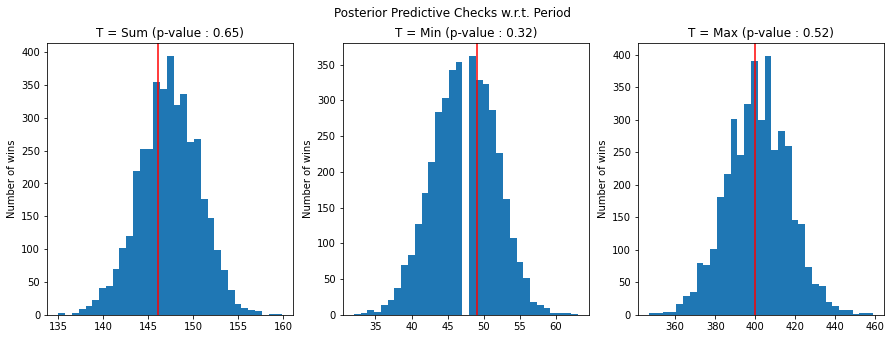

In [32]:
plot_ppc(score_pp_vi, observed_data,check, dim)

The simulated and generated data are good fit in terms of $T$=Max. However, for $T$=Min and $T$=Sum, we observe slightly off results for $T$=Sum, and $T$=Min. This may be due to the simple, mean-field, variational approximation that we are using. 

**MAP Algorithm:**

Unfortunately, we cannot perform posterior predictive checks for MAP algorithm. Therefore, we plot the...

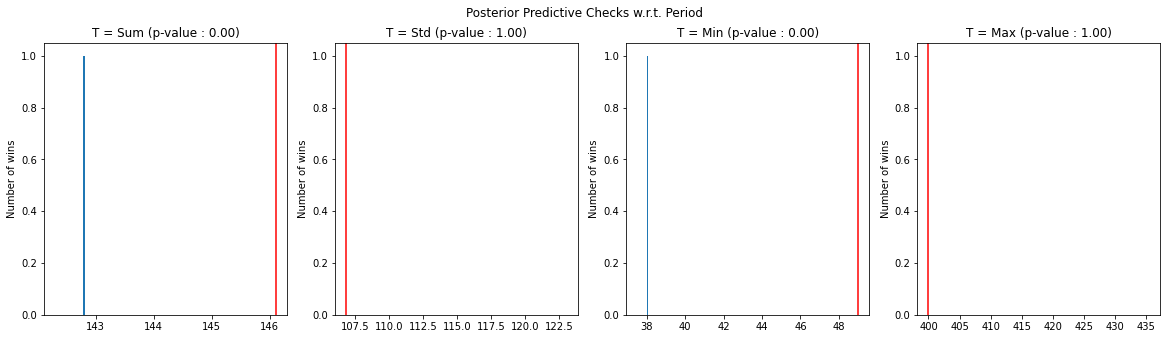

In [23]:
plot_ppc(score_pp_map, observed_data, check, dim)

**Glickman's Algorithm:**

Below, we see the posterior predictive checks (with Bayesian p-values) for the **Glickman's** algorithm:

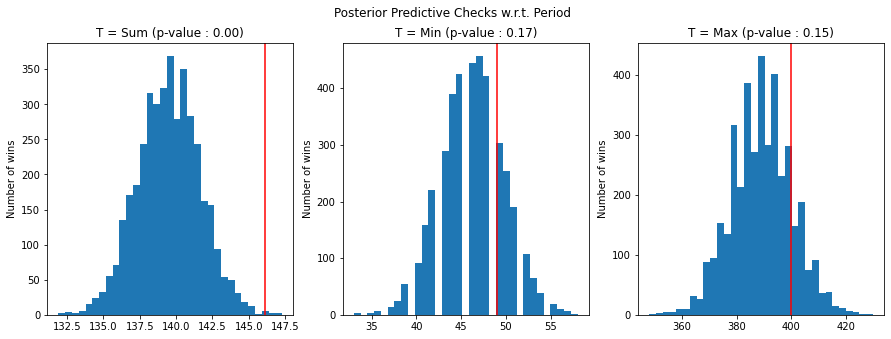

In [34]:
plot_ppc(score_pp_glickman, observed_data, check, dim)

### 2.Performance Comparisons:


In [ ]:
from criticism.criticism import evaluate_models

evaluate_models(
    y=data["score_test"],
    model_MCMC=model_MCMC, 
    model_VB=model_VB, 
    model_MLE=model_MLE,
    model_glicko=glicko_test_probs
)